#Get the dataset:

In [1]:
%cd /content/
!rm -rf data
!mkdir data
%cd data
!gdown --id 1u_8nuUl6lYr1c5MNsCT3z7hLXUIGWFYg
!unzip imdb.zip

/content
/content/data
Downloading...
From: https://drive.google.com/uc?id=1u_8nuUl6lYr1c5MNsCT3z7hLXUIGWFYg
To: /content/data/imdb.zip
100% 1.92M/1.92M [00:00<00:00, 30.4MB/s]
Archive:  imdb.zip
  inflating: boxoffice.json          
  inflating: imdb.json               


#Import necessary packages:

In [38]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import datetime
import random
import collections
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, normalize, StandardScaler
from sklearn.metrics import mean_absolute_error as mae

#Load the dataset:

In [3]:
%cd /content/
movies = []
box_office = dict()
with open("data/boxoffice.json", "r") as file:
    for line in file.read().splitlines():
        movie = json.loads(line)
        box_office[movie["url"]] = movie
with open("data/imdb.json", "r", encoding="utf8") as file:
    for line in file.read().splitlines():
        try:
            movie = json.loads(line)
        except:
            continue
        try:
            gross = box_office[movie["url"]]
        except KeyError:
            continue
        for key in gross.keys():
            if key != "url" and key != "title":
                movie[key] = gross[key]
        movies.append(movie)

for i in range(10):
    print(movies[i])

/content
{'title': 'Justice Society: World War II', 'rating': '6.3', 'date': '2021-04-27', 'genre': ['Animation', 'Action', 'Adventure', 'Fantasy', 'Sci-Fi'], 'actor': [{'@type': 'Person', 'url': '/name/nm1065664/', 'name': 'Stana Katic'}, {'@type': 'Person', 'url': '/name/nm0093589/', 'name': 'Matt Bomer'}, {'@type': 'Person', 'url': '/name/nm1859475/', 'name': 'Omid Abtahi'}, {'@type': 'Person', 'url': '/name/nm0034309/', 'name': 'Geoffrey Arend'}], 'director': {'@type': 'Person', 'url': '/name/nm5208146/', 'name': 'Jeff Wamester'}, 'creator': [{'@type': 'Person', 'url': '/name/nm4287835/', 'name': 'Jeremy Adams'}, {'@type': 'Person', 'url': '/name/nm5593068/', 'name': 'Meghan Fitzmartin'}, {'@type': 'Organization', 'url': '/company/co0038332/'}, {'@type': 'Organization', 'url': '/company/co0072876/'}], 'duration': 'PT1H24M', 'rating_count': 2433, 'content_rating': 'PG-13', 'oscar': None, 'metascore': None, 'url': '/title/tt13804084/', 'budget': None, 'opening': None, 'domestic': Non

#Clean the data:

In [4]:
# utils:
def time_str_to_num(time):
    if time[:2] == "PT":
        h = 0
        m = 0
        if "H" in time:
            h = int(time[2:time.index("H")])
            if "M" in time:
                m = int(time[time.index("H") + 1:-1])
        else:
            m = int(time[2:-1])
        return h * 60 + m
    else:
        return None


def budget_str_to_num(budget):
    return int(budget.replace("$", "").replace(",", ""))

In [11]:
cleaned_data = []
for i in range(len(movies)):
    movie = dict()
    try:
        movie["rating"] = float(movies[i]["rating"])
        date = datetime.datetime.strptime(movies[i]["date"], "%Y-%m-%d")
    except:
        continue
    movie["day"] = date.day
    movie["month"] = date.month
    movie["year"] = date.year
    movie["duration"] = time_str_to_num(movies[i]["duration"])
    try:
        movie["rating_count"] = int(movies[i]["rating_count"])
    except:
        movie["rating_count"] = None
    try:
        movie["metascore"] = int(movies[i]["metascore"])
    except:
        movie["metascore"] = None    
    try:
        movie["budget"] = budget_str_to_num(movies[i]["budget"])
    except:
        movie["budget"] = None
    try:
        movie["worldwide"] = budget_str_to_num(movies[i]["worldwide"])
    except:
        movie["worldwide"] = None
    movie["oscar"] = 1 if movies[i]["oscar"] else 0
    movie["genre"] = movies[i]["genre"]
    movie["content_rating"] = movies[i]["content_rating"]
    
    l = []
    if type(movies[i]["actor"]) == list:
        for person in movies[i]["actor"]:
            try:
                if person["@type"] == "Person":
                    l.append(person["name"])
            except KeyError:
                continue
    else:
        try:
            if person["@type"] == "Person":
                l.append(person["name"])
        except KeyError:
            continue
    movie["actor"] = l

    l = []
    if type(movies[i]["director"]) == list:
        for person in movies[i]["director"]:
            try:
                if person["@type"] == "Person":
                    l.append(person["name"])
            except KeyError:
                continue
    else:
        try:
            if person["@type"] == "Person":
                l.append(person["name"])
        except KeyError:
            continue
    movie["director"] = l

    l = []
    l1 = []
    if type(movies[i]["creator"]) == list:
        for person in movies[i]["creator"]:
            try:
                if person["@type"] == "Person":
                    l.append(person["name"])
                else:
                    l1.append(person["url"])
            except KeyError:
                continue
    else:
        try:
            if person["@type"] == "Person":
                l.append(person["name"])
            else:
                l1.append(person["url"])
        except KeyError:
            continue
    movie["creator"] = l
    movie["organization"] = l1

    cleaned_data.append(movie)

for i in range(10):
    print(cleaned_data[i])

{'rating': 6.3, 'day': 27, 'month': 4, 'year': 2021, 'duration': 84, 'rating_count': 2433, 'metascore': None, 'budget': None, 'worldwide': None, 'oscar': 0, 'genre': ['Animation', 'Action', 'Adventure', 'Fantasy', 'Sci-Fi'], 'content_rating': 'PG-13', 'actor': ['Stana Katic', 'Matt Bomer', 'Omid Abtahi', 'Geoffrey Arend'], 'director': ['Geoffrey Arend'], 'creator': ['Jeremy Adams', 'Meghan Fitzmartin'], 'organization': ['/company/co0038332/', '/company/co0072876/']}
{'rating': 2.6, 'day': 16, 'month': 4, 'year': 2021, 'duration': 96, 'rating_count': 1875, 'metascore': None, 'budget': None, 'worldwide': None, 'oscar': 0, 'genre': ['Action', 'Crime', 'Thriller'], 'content_rating': 'R', 'actor': ['Morgan Freeman', 'Ruby Rose', 'Patrick Muldoon', 'Nick Vallelonga'], 'director': ['Nick Vallelonga'], 'creator': ['Samuel Bartlett', 'George Gallo', 'Samuel Bartlett'], 'organization': ['/company/co0640069/', '/company/co0300747/']}
{'rating': 5.6, 'day': 22, 'month': 4, 'year': 2021, 'duration'

#Show some stats & plots:

In [7]:
%matplotlib inline

##Một số thống kê cơ bản:

Phân bố IMDB rating:
+ Khá đều, không quá lệch về một bên

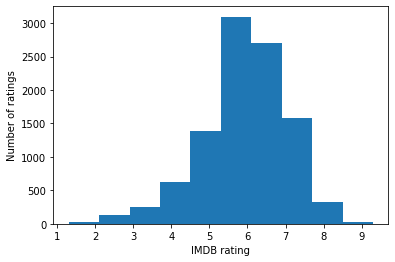

In [ ]:
ratings = []
for movie in cleaned_data:
    ratings.append(movie["rating"])
plt.hist(ratings, bins=10)
plt.xlabel("IMDB rating")
plt.ylabel("Number of ratings")
plt.show()

Tỷ lệ các thể loại:
+ Có tổng cộng 20 thể loại => có thể sử dụng one-hot encoding.

There are 20 genres: ['Animation', 'Action', 'Adventure', 'Fantasy', 'Sci-Fi', 'Crime', 'Thriller', 'Drama', 'War', 'Comedy', 'Family', 'Horror', 'Mystery', 'Musical', 'Romance', 'Music', 'Biography', 'History', 'Sport', 'Western']


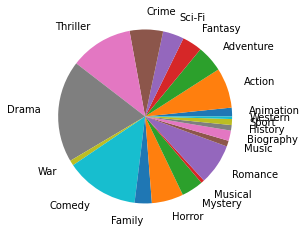

In [9]:
genres = []
for movie in cleaned_data:
    if type(movie["genre"]) == list:
        genres.extend(movie["genre"])
    else:
        genres.append(movie["genre"])
genres = collections.Counter(genres)
key = genres.keys()
count = genres.values()
print("There are %d genres:" % (len(key)), list(key))
plt.pie(count, labels=key, labeldistance=1.2)
plt.show()

Tương quan giữa thể loại và IMDB rating:
+ Các thể loại có trung bình IMDB rating khá tương đồng nhau.

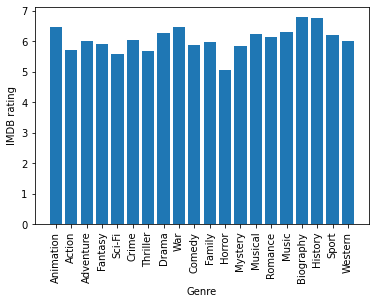

In [ ]:
genres = dict()
for movie in cleaned_data:
    for genre in movie["genre"] if type(movie["genre"]) == list else [movie["genre"]]:
        if genre not in genres:
            genres[genre] = list()
        genres[genre].append(movie["rating"])
for key in genres:
    genres[key] = np.mean(genres[key])
plt.bar(genres.keys(), genres.values())
plt.xlabel("Genre")
plt.ylabel("IMDB rating")
plt.xticks(rotation='vertical')
plt.show()

Tỷ lệ các content rating:
+ Có tổng cộng 16 => có thể sử dụng one-hot encoding.

There are 16 content ratings: ['R', 'PG-13', 'Not Rated', 'PG', 'TV-MA', 'Unrated', 'G', 'TV-14', 'TV-PG', 'TV-G', 'TV-Y7', 'TV-Y', 'NC-17', 'TV-Y7-FV', 'TV-13', 'X']


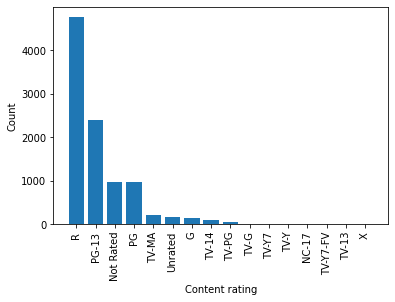

In [22]:
content_ratings = []
for movie in cleaned_data:
    if movie["content_rating"]:
        content_ratings.append(movie["content_rating"])
content_ratings = collections.Counter(content_ratings).most_common()
key = [x[0] for x in content_ratings]
count = [x[1] for x in content_ratings]
print("There are %d content ratings:" % (len(key)), list(key))
plt.bar(key, count)
plt.xlabel("Content rating")
plt.ylabel("Count")
plt.xticks(rotation="vertical")
plt.show()

Tương quan giữa content rating với doanh thu toàn cầu:
+ Giới hạn càng ít doanh thu càng cao => dễ hiểu.

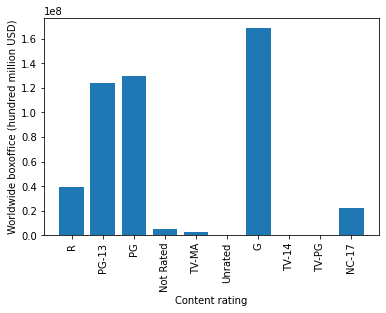

In [23]:
content_ratings = dict()
for movie in cleaned_data:
    if movie["content_rating"] and movie["worldwide"]:
        if movie["content_rating"] not in content_ratings:
            content_ratings[movie["content_rating"]] = list()
        content_ratings[movie["content_rating"]].append(movie["worldwide"])
for cr in content_ratings:
    content_ratings[cr] = np.mean(content_ratings[cr])
plt.bar(content_ratings.keys(), content_ratings.values())
plt.xlabel("Content rating")
plt.ylabel("Worldwide boxoffice (hundred million USD)")
plt.xticks(rotation="vertical")
plt.show()

Không có nhiều liên quan giữa content rating và IMDB rating, khác với doanh thu.

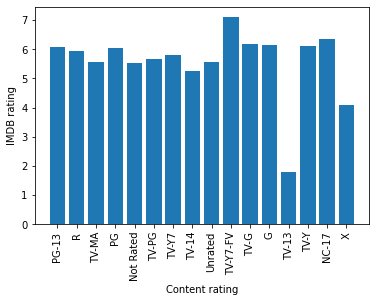

In [26]:
content_ratings = dict()
for movie in cleaned_data:
    if movie["content_rating"]:
        if movie["content_rating"] not in content_ratings:
            content_ratings[movie["content_rating"]] = list()
        content_ratings[movie["content_rating"]].append(movie["rating"])
for cr in content_ratings:
    content_ratings[cr] = np.mean(content_ratings[cr])
plt.bar(content_ratings.keys(), content_ratings.values())
plt.xlabel("Content rating")
plt.ylabel("IMDB rating")
plt.xticks(rotation="vertical")
plt.show()

Thống kê số lượng diễn viên, đạo diễn, nhà làm phim:

In [ ]:
counts = []
for movie in cleaned_data:
    if type(movie["actor"]) == list:
        counts.extend(movie["actor"])
    else:
        counts.append(movie["actor"])
counts = collections.Counter(counts)
key = counts.keys()
print("There are %d actors" % (len(key)))

counts = []
for movie in cleaned_data:
    if type(movie["director"]) == list:
        counts.extend(movie["director"])
    else:
        counts.append(movie["director"])
counts = collections.Counter(counts)
key = counts.keys()
print("There are %d directors" % (len(key)))

counts = []
for movie in cleaned_data:
    if type(movie["creator"]) == list:
        counts.extend(movie["creator"])
    else:
        counts.append(movie["creator"])
counts = collections.Counter(counts)
key = counts.keys()
print("There are %d creators" % (len(key)))

counts = []
for movie in cleaned_data:
    if type(movie["organization"]) == list:
        counts.extend(movie["organization"])
    else:
        counts.append(movie["organization"])
counts = collections.Counter(counts)
key = counts.keys()
print("There are %d organizations" % (len(key)))

There are 14955 actors
There are 7757 directors
There are 12610 creators
There are 13300 organizations


##Các biểu đồ phân tích theo rating

###Chứng minh IMDB rating tác động tới doanh thu và tỷ lệ được đề cử oscar:

Tương quan giữa được đề cử oscar và IMDB rating:
+ IMDB rating càng cao thì càng nhiều cơ hội được đề cử oscar => IMDB rating tác động tới khả năng được đề cử oscar.

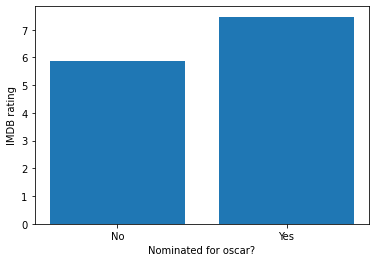

In [ ]:
x = ["No", "Yes"]
y = [list(), list()]
months = dict()
for movie in cleaned_data:
    y[movie["oscar"]].append(movie["rating"])
for i in range(len(y)):
    y[i] = np.mean(y[i])
plt.bar(x, y)
plt.xlabel("Nominated for oscar?")
plt.ylabel("IMDB rating")
plt.show()

Tương quan giữa doanh thu toàn cầu và IMDB rating:
+ Muốn đạt doanh thu cao bắt buộc phải có IMDB rating từ mức khá trở lên.
+ Những phim có doanh thu cao nhất đều có IMDB rating ở mức tốt (8.0)
=>  IMDB rating tác động tới doanh thu.

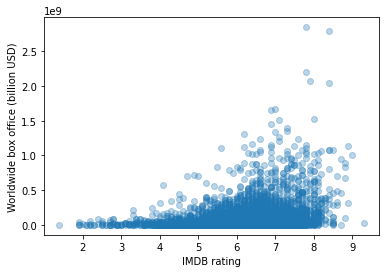

In [ ]:
x = []
y = []
for movie in cleaned_data:
    if not movie["rating"] or not movie["worldwide"]:
        continue
    x.append(movie["rating"])
    y.append(movie["worldwide"])
plt.scatter(x, y, alpha=0.3)
plt.xlabel("IMDB rating")
plt.ylabel("Worldwide box office (billion USD)")
plt.show()

###Các biểu đồ khác:

Tương quan giữa IMDB rating và kinh phí đầu tư:
+ Những phim có kinh phí cao (>= 200m USD) thường đem lại IMDB rating khá trở lên) => tiền là nhân tố quan trọng trong thành công của bộ phim.

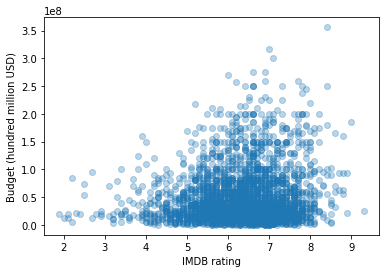

In [ ]:
x = []
y = []
for movie in cleaned_data:
    if not movie["budget"]:
        continue
    x.append(movie["rating"])
    y.append(movie["budget"])
plt.scatter(x, y, alpha=0.3)
plt.xlabel("IMDB rating")
plt.ylabel("Budget (hundred million USD)")
plt.show()

Tương quan giữa điểm IMDB (đánh giá của người xem bình thường) và metascore (đánh giá của nhà phê bình):
+ Nhìn chung điểm IMDB và metascore có quan hệ tuyến tính và đồng biến.

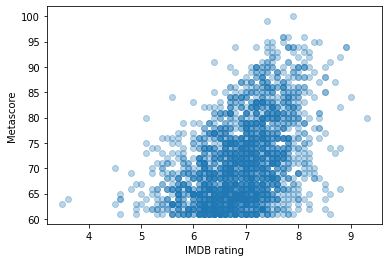

In [ ]:
x = []
y = []
for movie in cleaned_data:
    if not movie["rating"] or not movie["metascore"]:
        continue
    x.append(movie["rating"])
    y.append(movie["metascore"])
plt.scatter(x, y, alpha=0.3)
plt.xlabel("IMDB rating")
plt.ylabel("Metascore")
plt.show()

Số phim ra mắt mỗi tháng:

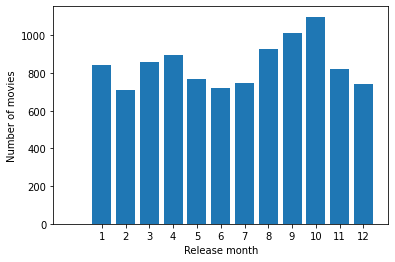

In [ ]:
x = np.arange(0, 13)
y = np.zeros((13,))
months = dict()
for movie in cleaned_data:
    if not movie["month"]:
        continue
    y[movie["month"]] += 1
plt.bar(x, y)
plt.xlabel("Release month")
plt.ylabel("Number of movies")
plt.xticks(range(1, 13))
plt.show()

Tương quan giữa IMDB rating và số lượt đánh giá:
+ Những phim được đánh giá nhiều thường có IMDB rating cao => quảng cáo phim nhiều sẽ có những lợi ích nhất định.

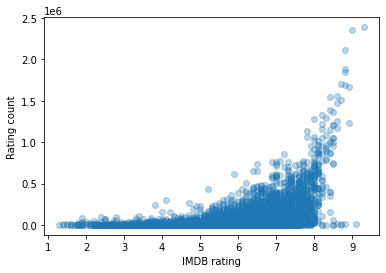

In [ ]:
x = []
y = []
for movie in cleaned_data:
    if not movie["rating"] or not movie["rating_count"]:
        continue
    x.append(movie["rating"])
    y.append(movie["rating_count"])
plt.scatter(x, y, alpha=0.3)
plt.xlabel("IMDB rating")
plt.ylabel("Rating count")
plt.show()

##Các biểu đồ phân tích doanh thu:

Tương quan giữa năm ra mắt và doanh thu: 
+ các phim ra sau thường doanh thu cao hơn.
+ riêng năm 2020 do đại dịch nên doanh thu giảm sút.
+ phần lớn phim có doanh thu <= 300m USD.

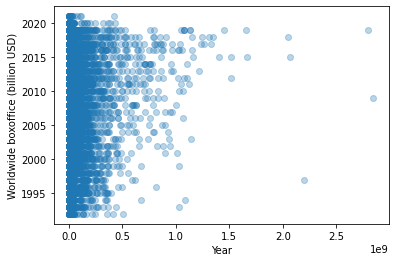

In [ ]:
x = []
y = []
for movie in cleaned_data:
    if not movie["year"] or not movie["worldwide"]:
        continue
    x.append(movie["worldwide"])
    y.append(movie["year"])
plt.scatter(x, y, alpha=0.3)
plt.xlabel("Year")
plt.ylabel("Worldwide boxoffice (billion USD)")
plt.show()

Trung bình doanh thu theo tháng:

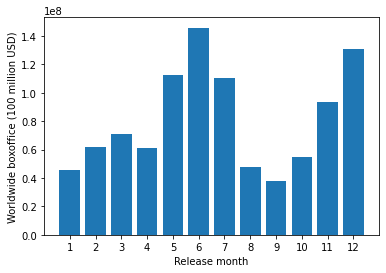

In [ ]:
x = []
y = []
months = dict()
for movie in cleaned_data:
    if not movie["month"] or not movie["worldwide"]:
        continue
    if movie["month"] not in months:
        months[movie["month"]] = list()
    months[movie["month"]].append(movie["worldwide"])
for key in months:
    x.append(key)
    y.append(np.mean(months[key]))
plt.bar(x, y)
plt.xlabel("Release month")
plt.ylabel("Worldwide boxoffice (100 million USD)")
plt.xticks(range(1, 13))
plt.show()

Trung bình doanh thu toàn cầu của các thể loại (tính từ 2010 trở lại):

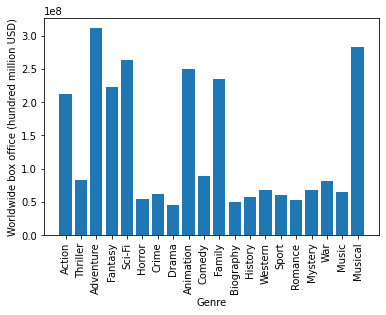

In [ ]:
genres = dict()
for movie in cleaned_data:
    if not movie["worldwide"] or movie["year"] < 2010:
        continue
    for genre in movie["genre"] if type(movie["genre"]) == list else [movie["genre"]]:
        if genre not in genres:
            genres[genre] = list()
        genres[genre].append(movie["worldwide"])
for key in genres:
    genres[key] = np.mean(genres[key])
plt.bar(genres.keys(), genres.values())
plt.xlabel("Genre")
plt.ylabel("Worldwide box office (hundred million USD)")
plt.xticks(rotation='vertical')
plt.show()

#Deep learning model to predict IMDB rating:

##First we preprocess the data:

In [6]:
# some utils:
class OneHotEncoding:
    def __init__(self, data):
        dictionary = dict()
        ind = 0
        for sample in data:
            if type(sample) == list:
                for s in sample:
                    if s not in dictionary:
                        dictionary[s] = ind
                        ind += 1
            else:
                if sample not in dictionary:
                    dictionary[sample] = ind
                    ind += 1
        self.dictionary, self.size = dictionary, ind # dictionary and its size

    def encode(self, data, handle_unknown="ignore"):
        new_data = np.zeros((len(data), self.size))
        for i in range(len(data)):
            sample = data[i]
            if type(sample) == list:
                for s in sample:
                    if s not in self.dictionary:
                        if handle_unknown == "ignore":
                            continue
                        else:
                            raise NotImplementedError("handle_unknown=%s is not implemented" % handle_unknown)
                    new_data[i][self.dictionary[s]] = 1
            else:
                if sample not in self.dictionary:
                    if handle_unknown == "ignore":
                        continue
                    else:
                        raise NotImplementedError("handle_unknown=%s is not implemented" % handle_unknown)
                new_data[i][self.dictionary[sample]] = 1
        return new_data

# test:            
a = OneHotEncoding([[1, 2], [4, 5], [1, 2, 6]])
print(a.encode([[1, 5], [4, 3], [1, 2, 6], [7]]))


[[1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0.]]


In [47]:
YEAR_LIMIT = 2000
BATCH_SIZE = 16
SPLIT_RATIO = (6, 2, 2) # train, val, test

data = []
actors = []
content_ratings = []
directors = []
creators = []
organizations = []

data_test = []
actors_test = []
content_ratings_test = []
directors_test = []
creators_test = []
organizations_test = []

for movie in cleaned_data:
    if movie["duration"] is None or movie["budget"] is None \
       or movie["content_rating"] is None or movie["year"] < YEAR_LIMIT:
        continue
    if random.random() >= SPLIT_RATIO[2]/10:
        actors.append(movie["actor"])
        content_ratings.append(movie["content_rating"])
        directors.append(movie["director"])
        creators.append(movie["creator"])
        organizations.append(movie["organization"])
        data.append([movie["rating"], movie["day"], movie["month"], 
                    movie["year"]-YEAR_LIMIT, 
                    movie["duration"], movie["budget"]])
    else:
        actors_test.append(movie["actor"])
        content_ratings_test.append(movie["content_rating"])
        directors_test.append(movie["director"])
        creators_test.append(movie["creator"])
        organizations_test.append(movie["organization"])
        data_test.append([movie["rating"], movie["day"], movie["month"], 
                          movie["year"]-YEAR_LIMIT, 
                          movie["duration"], movie["budget"]])
        
dictionary = []

enc = OneHotEncoding(actors)
actors = enc.encode(actors)
dictionary.append(enc)

enc = OneHotEncoding(content_ratings)
content_ratings = enc.encode(content_ratings)
dictionary.append(enc)

enc = OneHotEncoding(directors)
directors = enc.encode(directors)
dictionary.append(enc)

enc = OneHotEncoding(creators)
creators = enc.encode(creators)
dictionary.append(enc)

enc = OneHotEncoding(organizations)
organizations = enc.encode(organizations)
dictionary.append(enc)

with open("dict.pkl", "wb") as file:
    pickle.dump(dictionary, file)

for i in range(len(data)):
    data[i].extend(actors[i])
    data[i].extend(content_ratings[i])
    data[i].extend(directors[i])
    data[i].extend(creators[i])
    data[i].extend(organizations[i])

data = np.asarray(data).astype(np.float64)

Training dataset: 1453. Validation dataset: 485.
Training data shape: (1453, 10952)
Train
Features: [ 0.00011684 -0.00660143 -0.00878971 ... -0.00019099 -0.00019099
 -0.00019099], Label: 5.5
Features: [-0.00908626 -0.00270082  0.00451621 ... -0.00029571 -0.00029571
 -0.00029571], Label: 6.7
Features: [-0.01805113 -0.00212089 -0.00357033 ... -0.00023221 -0.00023221
 -0.00023221], Label: 7.3
Features: [-0.00238639 -0.01147296  0.00556515 ... -0.00024265 -0.00024265
 -0.00024265], Label: 7.2
Features: [ 0.00706672  0.0092297  -0.00848455 ... -0.00022118 -0.00022118
 -0.00022118], Label: 6.6
Features: [-0.00655087  0.00418636 -0.01772544 ... -0.00025686 -0.00025686
 -0.00025686], Label: 6.6
Features: [-0.00708319  0.00961961 -0.00177807 ... -0.00023052 -0.00023052
 -0.00023052], Label: 6.5
Features: [ 0.01578657  0.00788814  0.01456746 ... -0.00027187 -0.00027187
 -0.00027187], Label: 6.7
Features: [-0.00606275  0.01294282 -0.00729776 ... -0.00023772 -0.00023772
 -0.00023772], Label: 6.6
F

You can ignore your newly created data above and load your old data from file:

In [69]:
with open("raw_train_data.pkl", "rb") as file:
    data = pickle.load(file)

...and continue:

In [70]:
np.random.shuffle(data)

# splits data, label and does normalizing & scaling data
scaler = StandardScaler()
# y, X = data[:, 0], normalize(scale(data[:, 1:]))
y, X = data[:, 0], normalize(scaler.fit_transform(data[:, 1:]))

# train, test, val split:
X_train, X_val, y_train, y_val \
    = train_test_split(X, y, random_state=1,
                       test_size=SPLIT_RATIO[1]/(SPLIT_RATIO[0]+SPLIT_RATIO[1]))

# creates tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# dataset infomation:
print("Training dataset: %d. Validation dataset: %d." 
      % (X_train.shape[0], X_val.shape[0]))
print("Training data shape:", X_train.shape)

# displays first 10 training datapoints:
print("Train")
for feat, targ in train_dataset.take(10):
    print ('Features: {}, Label: {}'.format(feat, targ))

# batchs the dataset
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

Training dataset: 1453. Validation dataset: 485.
Training data shape: (1453, 10952)
Train
Features: [ 0.00112428  0.00314038  0.00294271 ... -0.00019268 -0.00019268
 -0.00019268], Label: 5.2
Features: [ 0.00471939 -0.00633338 -0.02000339 ... -0.00028987 -0.00028987
 -0.00028987], Label: 6.4
Features: [ 0.00822487 -0.01217129 -0.01776456 ... -0.00025742 -0.00025742
 -0.00025742], Label: 6.1
Features: [ 0.00906894 -0.01283367  0.01146152 ... -0.00021391 -0.00021391
 -0.00021391], Label: 5.4
Features: [ 0.01428724  0.01054961 -0.00446375 ... -0.00019376 -0.00019376
 -0.00019376], Label: 5.3
Features: [-0.01823458  0.00084035 -0.00720118 ... -0.00023457 -0.00023457
 -0.00023457], Label: 5.2
Features: [-0.00689441 -0.00152937  0.00127437 ... -0.00016745 -0.00016745
 -0.00016745], Label: 6.1
Features: [-0.01079367 -0.00212479  0.01603029 ... -0.00023264 -0.00023264
 -0.00023264], Label: 6.9
Features: [-0.0115295   0.00259145  0.00973787 ... -0.000159   -0.000159
 -0.000159  ], Label: 7.7
Fea

##Define a simple DNN model:

In [71]:
# number of features
n = X_train.shape[1]

model = tf.keras.Sequential([                         
    tf.keras.layers.Dense(n, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
              loss=tf.keras.losses.mean_squared_error,
              metrics=tf.keras.metrics.MAE)

##Training our model:

Mounts your drive to safely store best model:

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Trains:

In [49]:
EPOCHS = 40
# CHECKPOINT_PATH = "/content/drive/MyDrive/logging_colab/movies/imdb.ckpt"
CHECKPOINT_PATH = "/content/checkpoint/imdb.ckpt"

def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    elif epoch < 30:
        return lr * 0.1
    else:
        return lr * 0.01

lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH,
    save_weights_only=True,
    monitor='val_mean_absolute_error',
    mode='min',
    save_best_only=True)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS,
                    callbacks=[lr_scheduler_callback])

Epoch 1/40
91/91 [==============================] - 2s 23ms/step - loss: 17.3993 - mean_absolute_error: 3.3526 - val_loss: 0.9383 - val_mean_absolute_error: 0.7437
Epoch 2/40
91/91 [==============================] - 2s 22ms/step - loss: 0.9931 - mean_absolute_error: 0.7789 - val_loss: 0.9231 - val_mean_absolute_error: 0.7383
Epoch 3/40
91/91 [==============================] - 2s 22ms/step - loss: 0.9668 - mean_absolute_error: 0.7692 - val_loss: 0.9294 - val_mean_absolute_error: 0.7401
Epoch 4/40
91/91 [==============================] - 2s 22ms/step - loss: 0.9442 - mean_absolute_error: 0.7597 - val_loss: 0.9225 - val_mean_absolute_error: 0.7373
Epoch 5/40
91/91 [==============================] - 2s 22ms/step - loss: 0.9387 - mean_absolute_error: 0.7479 - val_loss: 0.9192 - val_mean_absolute_error: 0.7362
Epoch 6/40
91/91 [==============================] - 2s 22ms/step - loss: 0.9403 - mean_absolute_error: 0.7526 - val_loss: 0.9139 - val_mean_absolute_error: 0.7350
Epoch 7/40
91/91 [===

Saves the model (the latest epoch):

In [50]:
CHECKPOINT_PATH = "/content/drive/MyDrive/logging_colab/movies/imdb.ckpt"

model.save_weights(CHECKPOINT_PATH)

Run if you wanna load your pretrained model:

In [72]:
CHECKPOINT_PATH = "/content/drive/MyDrive/logging_colab/movies/imdb.ckpt"

model.load_weights(CHECKPOINT_PATH)

##Testing your model:

Loads your dictionary and preprocesses the test set:

In [52]:
with open("dict.pkl", "rb") as file:
    enc = pickle.load(file)

actors_test = enc[0].encode(actors_test)
content_ratings_test = enc[1].encode(content_ratings_test)
directors_test = enc[2].encode(directors_test)
creators_test = enc[3].encode(creators_test)
organizations_test = enc[4].encode(organizations_test)

for i in range(len(data_test)):
    data_test[i].extend(actors_test[i])
    data_test[i].extend(content_ratings_test[i])
    data_test[i].extend(directors_test[i])
    data_test[i].extend(creators_test[i])
    data_test[i].extend(organizations_test[i])

data_test = np.asarray(data_test).astype(np.float64)



Test data shape: (507, 10952)
Test
Features: [-0.00062828 -0.02643629  0.03008475 ...  0.          0.
  0.        ], Label: 6.6
Features: [-0.03736354 -0.038623    0.04395335 ...  0.          0.
  0.        ], Label: 8.3
Features: [0.00842474 0.03214021 0.032609   ... 0.         0.         0.        ], Label: 6.8
Features: [-0.03491605  0.05472603  0.06773718 ...  0.          0.
  0.        ], Label: 6.6
Features: [0.02879481 0.02974433 0.04719745 ... 0.         0.         0.        ], Label: 5.4
Features: [0.00086351 0.01150159 0.0182504  ... 0.         0.         0.        ], Label: 6.6
Features: [-0.02622531  0.01762841  0.02797226 ...  0.          0.
  0.        ], Label: 5.7
Features: [0.03100357 0.01868603 0.04129476 ... 0.         0.         0.        ], Label: 6.4
Features: [0.00450603 0.0108452  0.02396709 ... 0.         0.         0.        ], Label: 6.1
Features: [-0.00726454  0.01404353  0.03103516 ...  0.          0.
  0.        ], Label: 6.3


You can ignore your newly created data above and load your old data from file:

In [73]:
with open("raw_test_data.pkl", "rb") as file:
    data_test = pickle.load(file)

...and continue:

In [74]:
# splits data, label and does normalizing & scaling data
scaler = StandardScaler()
y_test, X_test = data_test[:, 0], normalize(scaler.fit_transform(data_test[:, 1:]))

# creates tensorflow datasets
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# dataset infomation:
print("Test data shape:", X_test.shape)

# displays first 10 testing datapoints:
print("Test")
for feat, targ in test_dataset.take(10):
    print ('Features: {}, Label: {}'.format(feat, targ))

# batchs the dataset
test_dataset = test_dataset.batch(BATCH_SIZE)

Test data shape: (507, 10952)
Test
Features: [-0.00062828 -0.02643629  0.03008475 ...  0.          0.
  0.        ], Label: 6.6
Features: [-0.03736354 -0.038623    0.04395335 ...  0.          0.
  0.        ], Label: 8.3
Features: [0.00842474 0.03214021 0.032609   ... 0.         0.         0.        ], Label: 6.8
Features: [-0.03491605  0.05472603  0.06773718 ...  0.          0.
  0.        ], Label: 6.6
Features: [0.02879481 0.02974433 0.04719745 ... 0.         0.         0.        ], Label: 5.4
Features: [0.00086351 0.01150159 0.0182504  ... 0.         0.         0.        ], Label: 6.6
Features: [-0.02622531  0.01762841  0.02797226 ...  0.          0.
  0.        ], Label: 5.7
Features: [0.03100357 0.01868603 0.04129476 ... 0.         0.         0.        ], Label: 6.4
Features: [0.00450603 0.0108452  0.02396709 ... 0.         0.         0.        ], Label: 6.1
Features: [-0.00726454  0.01404353  0.03103516 ...  0.          0.
  0.        ], Label: 6.3


Testing and plots the results:

32/32 [==============================] - 1s 6ms/step - loss: 0.6803 - mean_absolute_error: 0.6261
Test loss MSE, MAE: [0.6615160703659058, 0.6341835856437683]


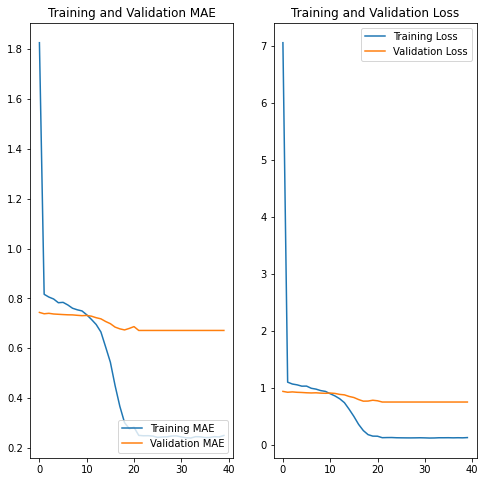

In [75]:
# Testing:
results = model.evaluate(test_dataset, batch_size=16)
print("Test loss MSE, MAE:", results)

# Plotting:
acc = history.history['mean_absolute_error']
val_acc = history.history['val_mean_absolute_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training MAE')
plt.plot(epochs_range, val_acc, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Save the training, validation and testing dataset for further use:

In [67]:
with open("raw_test_data.pkl", "wb") as file:
    pickle.dump(data_test, file)
with open("raw_train_data.pkl", "wb") as file:
    pickle.dump(data, file)

In [68]:
%cd /content/
!zip data.zip -r raw_test_data.pkl raw_train_data.pkl

/content
updating: raw_test_data.pkl (deflated 100%)
  adding: raw_train_data.pkl (deflated 100%)
